# PCA + OLS estimation: DFM
---

> A partir dos componentes principais, que são os estimadores dos fatores, extraídos no script 'dfm_pca.ipynb', podemos estimar o primeiro modelo por MQO, em uma regressão do PIB em k fatores.

## Bibliotecas

In [275]:
import pandas as pd
import numpy as np
import datetime as dt

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col

from stargazer.stargazer import Stargazer
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from math import sqrt

## Carregando os dados 

In [276]:
# Carregando dados tratados e separando a variável-alvo: o PIB

data = pd.read_csv('../../data/data_tf.csv')
# data['Date'] = pd.date_range(start = '2002-03-01', end = '2022-09-01', freq = 'QS-DEC') --> se fosse para trimestre 
data['Date'] = pd.date_range(start = '2002-01-01', end = '2022-09-01', freq = 'MS')
data.set_index('Date', inplace = True)
gdp = data['gdp']
qgdp = (gdp.groupby(pd.PeriodIndex(gdp.index, freq = 'Q'), axis = 0)).mean()
qgdp

Date
2002Q1         NaN
2002Q2    0.043207
2002Q3    0.035439
2002Q4   -0.002176
2003Q1   -0.047467
            ...   
2021Q3    0.025785
2021Q4   -0.004322
2022Q1   -0.002627
2022Q2    0.017867
2022Q3    0.024755
Freq: Q-DEC, Name: gdp, Length: 83, dtype: float64

In [277]:
# Carregando os dados tranformados com PCA

data_pca = pd.read_csv('../../data/data_tfpca.csv')
# data['Date'] = pd.date_range(start = '2002-03-01', end = '2022-09-01', freq = 'QS-DEC') --> se fosse para trimestre 
data['Date'] = pd.date_range(start = '2002-01-01', end = '2022-09-01', freq = 'MS')
data_pca.set_index('Date', inplace = True)
data_pca.columns = data_pca.columns.str.replace(r"[C]", "F")
data_pca

C:\Users\HENRI\AppData\Local\Temp\ipykernel_11916\3990215449.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  data_pca.columns = data_pca.columns.str.replace(r"[C]", "F")


,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,...,F144,F145,F146,F147,F148,F149,F150,F151,F152,F153
Date,,,,,,,,,,,,,,,,,,,,,
2002-01-01,0.043761,-0.301327,0.281876,-0.469964,-0.480213,0.267495,4.052348,-1.266854,1.604325,-0.029623,...,-0.019268,-0.011269,0.016385,0.005315,0.001778,-0.003904,0.002835,-0.008273,0.000115,-0.000836
2002-02-01,-1.349206,-0.550805,0.872002,1.933582,-1.591338,2.024872,3.075690,-1.082151,1.912396,0.327998,...,-0.005614,-0.005969,0.004629,0.001635,-0.001375,0.000777,0.000238,0.001074,-0.000113,0.000139
2002-03-01,2.921580,2.328693,0.027064,0.010019,0.273320,-0.980296,3.500098,-1.881021,0.807566,-0.224126,...,-0.002009,-0.001144,-0.009077,0.000726,-0.000015,0.005581,0.000153,0.000019,-0.000366,0.000013
2002-04-01,0.364593,1.489715,1.174915,0.080800,0.057597,0.565341,2.975339,-0.501164,2.160204,0.724248,...,0.008764,0.003876,-0.006997,0.001256,0.000781,0.004618,0.000676,-0.000453,-0.000656,0.000220
2002-05-01,-0.021967,-0.240064,-0.508700,0.346847,-1.195284,0.596571,2.105202,-1.360489,1.832412,-2.509840,...,-0.005855,-0.002427,0.009588,0.003823,-0.008100,-0.001832,-0.000813,-0.000200,0.000281,0.000080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-01,5.656367,3.587253,-2.324899,-1.407377,-1.077000,-0.319084,0.803622,1.423434,0.346798,-5.502160,...,-0.007328,0.002691,0.002994,-0.015947,0.000663,0.001475,0.002949,-0.000332,0.000137,-0.000122
2022-06-01,-1.250367,-1.734443,0.124854,-0.019953,-3.158825,-2.717110,1.054606,4.052564,-4.752051,-3.012939,...,0.010011,-0.007922,-0.009917,-0.010737,-0.002821,0.003087,0.002478,-0.000240,0.000248,0.000119
2022-07-01,1.715190,1.555140,-1.784176,3.606715,4.031505,-0.911592,-1.827816,-1.529660,2.326015,1.587895,...,0.001867,0.009011,-0.006219,-0.001837,-0.000040,0.001809,-0.002318,0.000064,-0.000011,0.000101


## Preparando as variáveis

In [278]:
# Agrupando os fatores pela média para ficar na mesma frequência do PIB e preenchendo a primeira observação do PIB com a mediana 

qdata_pca = (data_pca.groupby(pd.PeriodIndex(data_pca.index, freq = 'Q'), axis = 0)).mean()
# qdata_pca.to_csv('../../data/qdata_tfpca.csv')
new_data = pd.merge(qgdp, qdata_pca, how='inner', left_index=True, right_index=True)
new_data.gdp.fillna(new_data.gdp.median(), inplace = True)
new_data['gdp'] = new_data['gdp'] * 100
new_data

,gdp,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F144,F145,F146,F147,F148,F149,F150,F151,F152,F153
Date,,,,,,,,,,,,,,,,,,,,,
2002Q1,0.388552,0.538712,0.492187,0.393648,0.491212,-0.599411,0.437357,3.542712,-1.410008,1.441429,...,-0.008964,-0.006128,0.003979,0.002559,0.000129,0.000818,0.001075,-2.393479e-03,-0.000121,-2.279415e-04
2002Q2,4.320709,-0.442968,-0.049328,-0.098923,0.011377,-0.766521,0.555046,2.055331,-1.683349,2.263962,...,-0.001609,0.000378,-0.002322,-0.000837,-0.002199,0.000739,0.000213,3.151107e-04,-0.000076,1.001810e-04
2002Q3,3.543887,0.424707,-0.647956,0.217876,-4.446846,-1.604402,1.708108,2.452098,0.985706,2.723189,...,0.001059,0.004871,0.000425,-0.004247,-0.002138,0.001481,-0.001209,8.372003e-05,-0.000030,4.005423e-07
2002Q4,-0.217573,-0.232993,-2.268012,6.315600,-11.643441,-3.549546,1.241341,2.347363,-0.177495,3.033051,...,0.001259,-0.002754,-0.004363,0.001607,0.002197,0.000537,0.001328,2.376067e-04,0.000069,7.265413e-05
2003Q1,-4.746729,-1.958564,0.865307,3.212400,-5.975119,-1.915151,0.577081,4.299099,-1.396467,0.792031,...,0.000778,-0.002990,0.005988,-0.000048,-0.000005,-0.000194,-0.000729,-1.147034e-04,0.000013,-1.006342e-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021Q3,2.578462,-0.342376,0.778500,2.328568,-1.987400,-0.206580,-0.136194,-1.399026,1.282804,-0.357813,...,0.004611,-0.005063,0.000703,0.001253,0.002736,0.002235,0.000898,8.420353e-05,0.000012,1.338558e-05
2021Q4,-0.432211,1.693068,-3.285857,2.140440,-3.050982,1.034121,-0.989648,-1.303261,1.347845,1.466352,...,-0.004558,-0.002717,0.002519,0.001794,-0.002586,-0.003522,-0.000852,2.367683e-04,0.000068,-1.073587e-04
2022Q1,-0.262737,-2.583732,2.756302,0.194961,-5.354888,-1.059385,1.439377,-0.281474,0.233960,-3.768976,...,0.001292,-0.006083,-0.000287,0.001759,0.000691,0.000952,0.000797,3.536963e-07,0.000185,-1.849388e-05


In [279]:
new_data_5fac = new_data[['gdp', 'F1', 'F2', 'F3', 'F4', 'F5']].copy()
new_data_5fac

,gdp,F1,F2,F3,F4,F5
Date,,,,,,
2002Q1,0.388552,0.538712,0.492187,0.393648,0.491212,-0.599411
2002Q2,4.320709,-0.442968,-0.049328,-0.098923,0.011377,-0.766521
2002Q3,3.543887,0.424707,-0.647956,0.217876,-4.446846,-1.604402
2002Q4,-0.217573,-0.232993,-2.268012,6.315600,-11.643441,-3.549546
2003Q1,-4.746729,-1.958564,0.865307,3.212400,-5.975119,-1.915151
...,...,...,...,...,...,...
2021Q3,2.578462,-0.342376,0.778500,2.328568,-1.987400,-0.206580
2021Q4,-0.432211,1.693068,-3.285857,2.140440,-3.050982,1.034121
2022Q1,-0.262737,-2.583732,2.756302,0.194961,-5.354888,-1.059385


In [280]:
# train and test dates

train_start_date = "2002-03-01"
train_end_date = "2017-12-01"
test_start_date = "2018-03-01"
test_end_date = "2022-09-01"

# train and test datasets

train = new_data.loc[(new_data.index >= train_start_date) & (new_data.index <= train_end_date), :]
test = new_data.loc[(new_data.index >= test_start_date) & (new_data.index <= test_end_date), :]

In [281]:
# Train dataset

X_train = train.drop('gdp', axis = 1)
y_train = train['gdp']

# Test dataset 

X_test = test.drop('gdp', axis = 1)
y_test = test['gdp']

In [282]:
y_train

Date
2002Q1    0.388552
2002Q2    4.320709
2002Q3    3.543887
2002Q4   -0.217573
2003Q1   -4.746729
            ...   
2016Q4   -1.908789
2017Q1   -0.036948
2017Q2    1.669439
2017Q3    1.957101
2017Q4   -1.004338
Freq: Q-DEC, Name: gdp, Length: 64, dtype: float64

# Modelos
---

## 1. DFM: regressão linear por MQO - 5 fatores utilizados

In [283]:
X5_train = X_train[['F1', 'F2', 'F3', 'F4', 'F5']].copy()
X5_test = X_test[['F1', 'F2', 'F3', 'F4', 'F5']].copy()

reg = smf.ols('gdp ~ F1 + F2 + F3 + F4 + F5', data = train)
dfm_ols_5fac = reg.fit()
print(dfm_ols_5fac.summary())

                            OLS Regression Results                            
Dep. Variable:                    gdp   R-squared:                       0.529
Model:                            OLS   Adj. R-squared:                  0.489
Method:                 Least Squares   F-statistic:                     13.04
Date:                Tue, 20 Dec 2022   Prob (F-statistic):           1.63e-08
Time:                        16:43:57   Log-Likelihood:                -129.41
No. Observations:                  64   AIC:                             270.8
Df Residuals:                      58   BIC:                             283.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5255      0.247      2.129      0.0

## 2. DFM: regressão linear MQO - 1 fator

In [284]:
reg = smf.ols('gdp ~ F1', data = train)
dfm_ols_1fac = reg.fit()
print(dfm_ols_1fac.summary())

                            OLS Regression Results                            
Dep. Variable:                    gdp   R-squared:                       0.166
Model:                            OLS   Adj. R-squared:                  0.152
Method:                 Least Squares   F-statistic:                     12.32
Date:                Tue, 20 Dec 2022   Prob (F-statistic):           0.000841
Time:                        16:43:57   Log-Likelihood:                -147.72
No. Observations:                  64   AIC:                             299.4
Df Residuals:                      62   BIC:                             303.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6504      0.309      2.104      0.0

In [285]:
stargazer = Stargazer([dfm_ols_1fac, dfm_ols_5fac])
stargazer.custom_columns(['1 Factor Model', '5 Factor Model'], [1, 1])
print(stargazer.render_latex())

\begin{table}[!htbp] \centering
\begin{tabular}{@{\extracolsep{5pt}}lcc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
& \multicolumn{2}{c}{\textit{Dependent variable:}} \
\cr \cline{2-3}
\\[-1.8ex] & \multicolumn{1}{c}{1 Factor Model} & \multicolumn{1}{c}{5 Factor Model}  \\
\\[-1.8ex] & (1) & (2) \\
\hline \\[-1.8ex]
 F1 & 0.627$^{***}$ & 1.394$^{***}$ \\
  & (0.179) & (0.238) \\
 F2 & & 0.331$^{***}$ \\
  & & (0.119) \\
 F3 & & -0.197$^{*}$ \\
  & & (0.108) \\
 F4 & & 0.295$^{**}$ \\
  & & (0.117) \\
 F5 & & -1.140$^{***}$ \\
  & & (0.231) \\
 Intercept & 0.650$^{**}$ & 0.526$^{**}$ \\
  & (0.309) & (0.247) \\
\hline \\[-1.8ex]
 Observations & 64 & 64 \\
 $R^2$ & 0.166 & 0.529 \\
 Adjusted $R^2$ & 0.152 & 0.489 \\
 Residual Std. Error & 2.472(df = 62) & 1.920(df = 58)  \\
 F Statistic & 12.321$^{***}$ (df = 1.0; 62.0) & 13.041$^{***}$ (df = 5.0; 58.0) \\
\hline
\hline \\[-1.8ex]
\textit{Note:} & \multicolumn{2}{r}{$^{*}$p$<$0.1; $^{**}$p$<$0.05; $^{***}$p$<$0.01} \\
\end{tabular}
\end{table}


# Previsões: DFM não atualizado

## Dentro da amostra

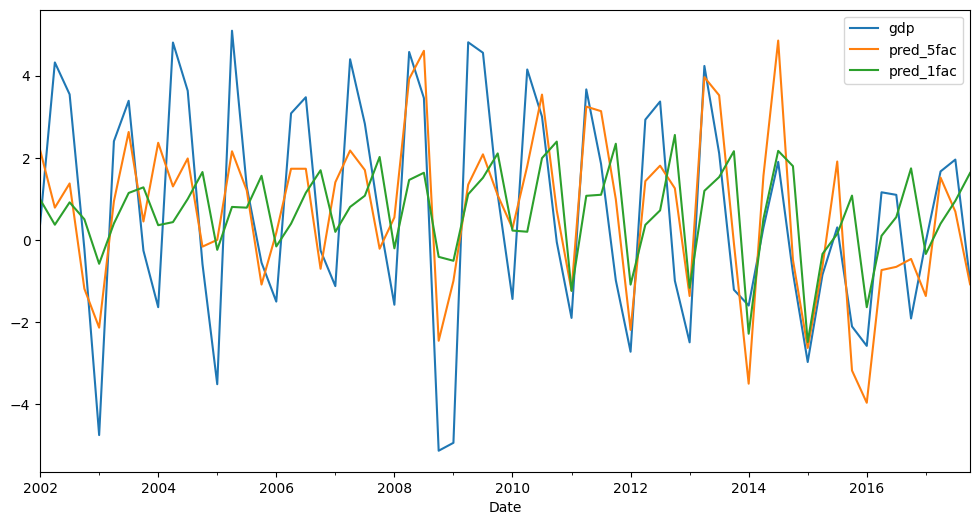

In [315]:
forecasts_insample = pd.DataFrame()
forecasts_insample['gdp'] = y_train
forecasts_insample['pred_5fac'] = dfm_ols_5fac.predict(X5_train)
forecasts_insample['pred_1fac'] = dfm_ols_1fac.predict(X5_train.F1)
forecasts_insample.plot(figsize = (12,6))
plt.savefig('dfm-images-plots/forecast_1and5_factors_insample.png')

### Métricas de previsão: dentro da amostra

In [290]:
rmse_insample_5fac = np.sqrt(((dfm_ols_5fac.predict(X5_train) - y_train) ** 2).mean())
mae_insample_5fac = ((dfm_ols_5fac.predict(X5_train) - y_train).abs()).mean()
print(rmse_insample_5fac, mae_insample_5fac, sep = '\n\n')

1.827842929311588

1.5208702710661632


In [291]:
rmse_insample_1fac = np.sqrt(((dfm_ols_1fac.predict(X5_train.F1) - y_train) ** 2).mean())
mae_insample_1fac = ((dfm_ols_1fac.predict(X5_train.F1) - y_train).abs()).mean()
print(rmse_insample_1fac, mae_insample_1fac, sep = '\n\n')

2.433237180665312

2.087072438552906


## Fora da amostra

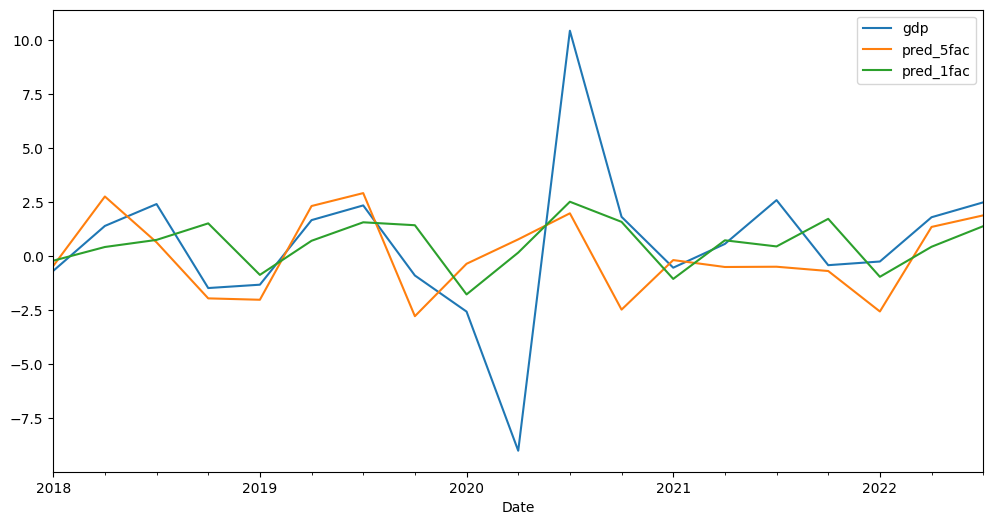

In [312]:
forecasts_outsample = pd.DataFrame()
forecasts_outsample['gdp'] = y_test
forecasts_outsample['pred_5fac'] = dfm_ols_5fac.predict(X5_test)
forecasts_outsample['pred_1fac'] = dfm_ols_1fac.predict(X5_test.F1)
forecasts_outsample.plot(figsize=(12,6))

### Métricas de previsão: fora da amostra

In [293]:
rmse_outsample_5fac = np.sqrt(((dfm_ols_5fac.predict(X5_test) - y_test) ** 2).mean())
mae_outsample_5fac = ((dfm_ols_5fac.predict(X5_test) - y_test).abs()).mean()
print(rmse_outsample_5fac, mae_outsample_5fac, sep = '\n\n')

3.381902325937125

2.1327012362540145


In [294]:
rmse_outsample_1fac = np.sqrt((( dfm_ols_1fac.predict(X5_test.F1) - y_test) ** 2).mean())
mae_outsample_1fac = ((dfm_ols_1fac.predict(X5_test.F1) - y_test).abs()).mean()
print(rmse_outsample_1fac, mae_outsample_1fac, sep = '\n\n')

3.082790098703324

1.9412879303639474


# Previsões: DFM atualizado

Usando um loop para reestimar e computar as novas previsões

## 5 fatores

In [295]:
test_5fac = test[['F1', 'F2', 'F3', 'F4', 'F5']].copy()
list_5fac = list()

reg = smf.ols('gdp ~ F1 + F2 + F3 + F4 + F5', data = new_data.loc['2002Q1':'2017Q4',])
dfm_5fac = reg.fit()
pred = dfm_5fac.predict(test_5fac.loc['2018Q1']).values[0]
list_5fac.append(pred)

for i, j in zip(test_5fac.index, new_data.loc['2018Q2':,].index):
    reg = smf.ols('gdp ~ F1 + F2 + F3 + F4 + F5', data = new_data.loc['2002Q1':i,])
    dfm_5fac = reg.fit()
    pred = dfm_5fac.predict(test_5fac.loc[j]).values[0]
    list_5fac.append(pred)

list_5fac

[-0.46919795405136316,
 2.74864684895456,
 0.5989023312090751,
 -1.8483330821643182,
 -1.977878965583903,
 2.2482716178087596,
 2.8689281558475916,
 -2.6354647692750093,
 -0.5278429573915773,
 0.24228208651476912,
 1.3959859191820165,
 -0.5179942431580921,
 -0.05812409476262381,
 0.5341087383939507,
 0.4144508154150295,
 0.3831980308614621,
 -1.3313868614543125,
 0.8305971406778356,
 1.7858433084479726]

## 1 fator

In [296]:
test_1fac = test[['F1']].copy()
list_1fac = list()

reg = smf.ols('gdp ~ F1', data = new_data.loc['2002Q1':'2017Q4',])
dfm_1fac = reg.fit()
pred = dfm_1fac.predict(test_1fac.loc['2018Q1']).values[0]
list_1fac.append(pred)

for i, j in zip(test_1fac.index, new_data.loc['2018Q2':,].index):
    reg = smf.ols('gdp ~ F1', data = new_data.loc['2002Q1':i,])
    dfm_1fac = reg.fit()
    pred = dfm_1fac.predict(test_1fac.loc[j]).values[0]
    list_1fac.append(pred)

list_1fac

[-0.22511040983436714,
 0.4005661807538234,
 0.7457942889564265,
 1.538487097529694,
 -0.848911905731383,
 0.6780245190446317,
 1.5310301054433642,
 1.4159129248763256,
 -1.734814816310719,
 0.11742319870716672,
 2.4265091542848554,
 1.708499605250144,
 -1.47902998710919,
 0.6896171449922639,
 0.35110497785383715,
 1.8947610837029154,
 -1.2743738885487255,
 0.3557678171378729,
 1.4597835575410192]

## Dataframe e gráfico de previsões fora da amostra

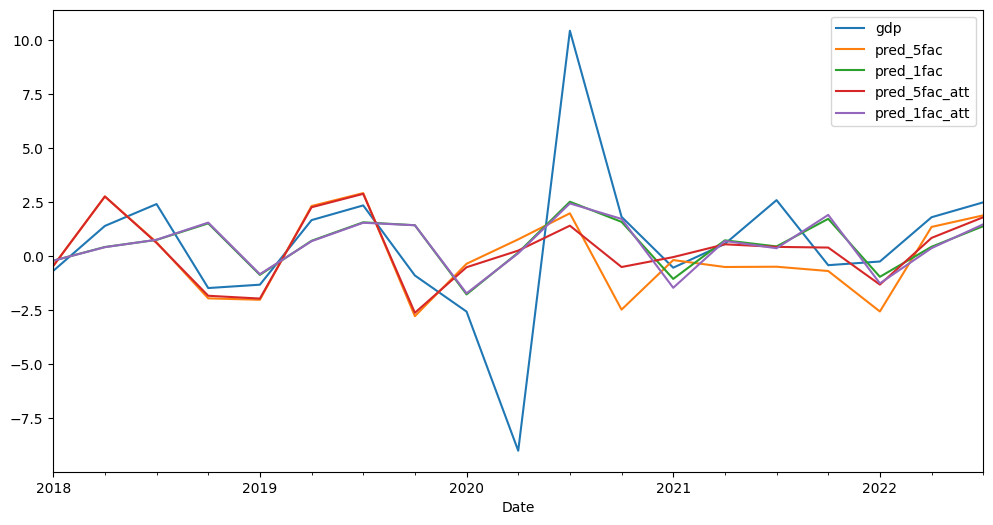

In [314]:
forecasts_outsample['pred_5fac_att'] = list_5fac
forecasts_outsample['pred_1fac_att'] = list_1fac
forecasts_outsample.plot(figsize = (12,6))
plt.savefig('dfm-images-plots/forecast_1and5_factors_outsample.png')

## Métricas de precisão: fora da amostra

In [307]:
rmse_outsample_5fac = np.sqrt(((forecasts_outsample['pred_5fac'] - forecasts_outsample['gdp']) ** 2).mean())
mae_outsample_5fac = ((forecasts_outsample['pred_5fac'] - forecasts_outsample['gdp']).abs()).mean()
print(rmse_outsample_5fac, mae_outsample_5fac, sep = '\n')

3.381902325937125
2.1327012362540145


In [308]:
rmse_outsample_1fac = np.sqrt(((forecasts_outsample['pred_1fac'] - forecasts_outsample['gdp']) ** 2).mean())
mae_outsample_1fac = ((forecasts_outsample['pred_1fac'] - forecasts_outsample['gdp']).abs()).mean()
print(rmse_outsample_1fac, mae_outsample_1fac, sep = '\n')

3.082790098703324
1.9412879303639474


In [309]:
rmse_outsample_5fac_att = np.sqrt(((forecasts_outsample['pred_5fac_att'] - forecasts_outsample['gdp']) ** 2).mean())
mae_outsample_5fac_att = ((forecasts_outsample['pred_5fac_att'] - forecasts_outsample['gdp']).abs()).mean()
print(rmse_outsample_5fac_att, mae_outsample_5fac_att, sep = '\n')

3.1977164484578124
1.9005002265647193


In [310]:
rmse_outsample_1fac_att = np.sqrt(((forecasts_outsample['pred_1fac_att'] - forecasts_outsample['gdp']) ** 2).mean())
mae_outsample_1fac_att = ((forecasts_outsample['pred_1fac_att'] - forecasts_outsample['gdp']).abs()).mean()
print(rmse_outsample_1fac_att, mae_outsample_1fac_att, sep = '\n')

3.110558357815622
1.9938627254225636
